In [101]:
import pymysql 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['font.family'] = 'AppleGothic'

In [102]:
cnx = pymysql.connect(user='*****', password='*****', host='ec2-15-152-211-160.ap-northeast-3.compute.amazonaws.com', database='Data_Mart')

query = 'SELECT * FROM Data_Mart.main_fs;' 
main_fs = pd.read_sql(query, cnx) 

query = 'SELECT * from Data_Warehouse.preprocessed;' 
preprocessed = pd.read_sql(query, cnx) 

cnx.close()

/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_76951/2359877828.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  main_fs = pd.read_sql(query, cnx)
/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_76951/2359877828.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preprocessed = pd.read_sql(query, cnx)


In [103]:
def symmetrical_log(x):
    return np.log1p(x) if x >= 0 else -np.log1p(-x)

def plot_metric_distribution(data, metric, ax):
    years = ['2018', '2019', '2020', '2021', '2022']
    metric_data = data[data['label_en'] == metric]
    long_format_data = pd.melt(metric_data, id_vars=['corp', 'label_en'], value_vars=years, var_name='year', value_name=metric)

    long_format_data['log_' + metric] = long_format_data[metric].apply(symmetrical_log)

    sns.kdeplot(x='log_' + metric, data=long_format_data, fill=True, alpha=0.5, ax=ax)
    ax.set_title(f"Log({metric.title()})")
    ax.set_xlabel(f"Log({metric.title()})")
    ax.set_ylabel("Density")

/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_76951/3821136382.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/sjparky/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


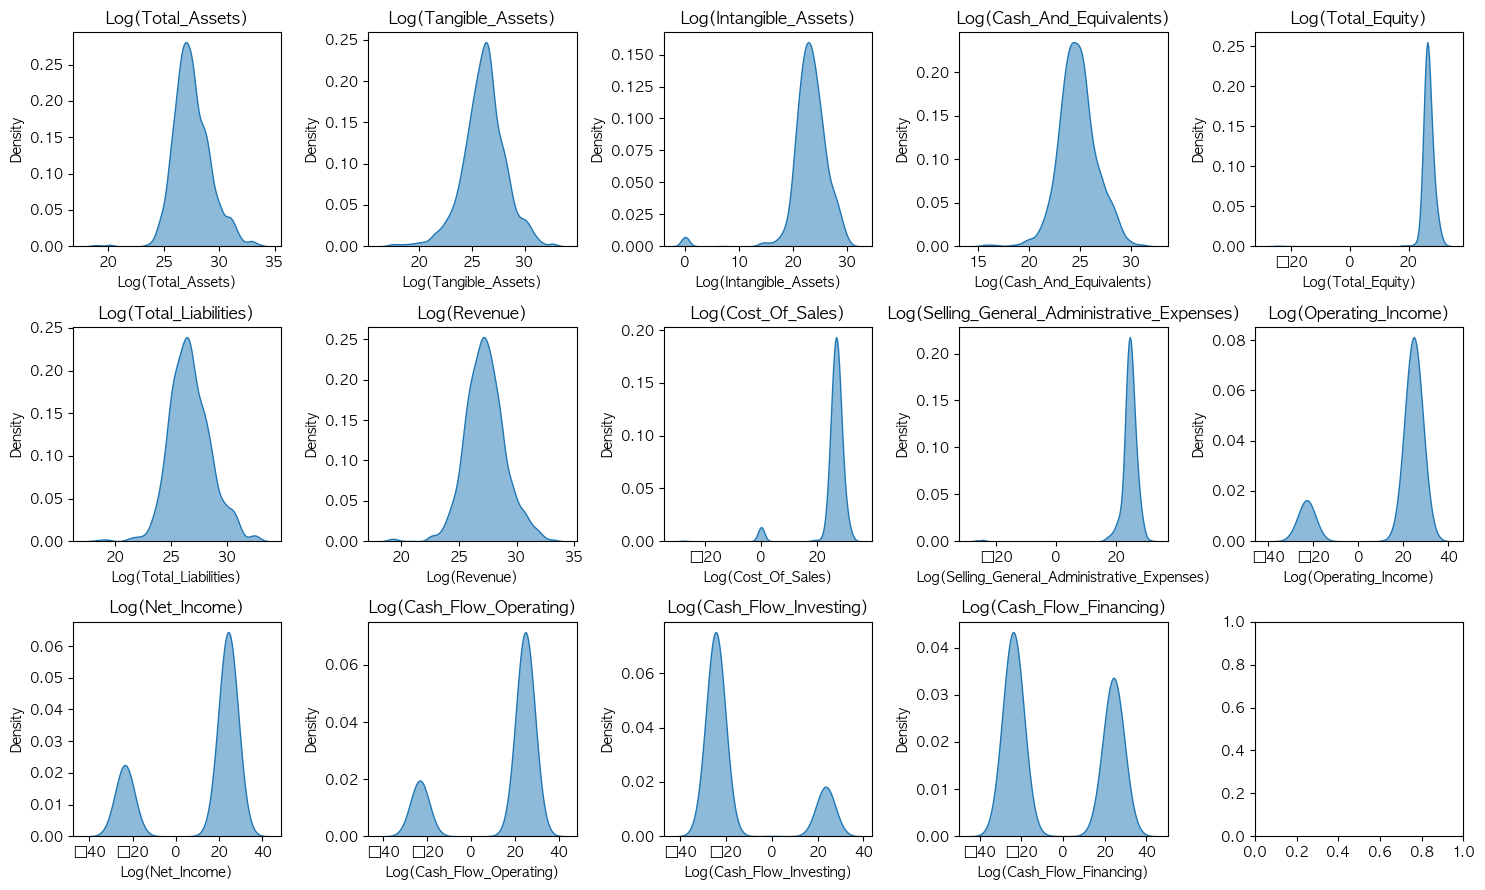

In [104]:
metrics = main_fs['label_en'].unique() 

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for metric, ax in zip(metrics, axes.flatten()):
    plot_metric_distribution(main_fs, metric, ax)

plt.tight_layout()
plt.show()

-ve 안되는 변수들: [total_assets, tangible_assets, intangible_assets, cash_and_equivalents, total_liabilities, revenue, cost_of_sales, selling_general_administrative_expenses]

-ve 괜찮은 변수들: [total_equity, operating_income, net_income, cash_flow_operating, cash_flow_investing, cash_flow_financing]

In [70]:
cannot_be_negative = ['total_assets', 'tangible_assets', 'intangible_assets', 'cash_and_equivalents', 'total_liabilities', 'revenue', 'cost_of_sales', 'selling_general_administrative_expenses']

for col in cannot_be_negative: 
    is_negative = (main_fs[main_fs['label_en'] == col][['2018', '2019', '2020', '2021', '2022']] < 0).any().any()
    print(f"{col} contains negative values: {is_negative}")

total_assets contains negative values: False
tangible_assets contains negative values: False
intangible_assets contains negative values: False
cash_and_equivalents contains negative values: False
total_liabilities contains negative values: False
revenue contains negative values: False
cost_of_sales contains negative values: True
selling_general_administrative_expenses contains negative values: True


In [71]:
cost_of_sales = main_fs[main_fs['label_en'] == 'cost_of_sales'] 
negative_values = (cost_of_sales[['2018', '2019', '2020', '2021', '2022']] < 0).any(axis=1)

rows_with_negative_values = cost_of_sales[negative_values]
rows_with_negative_values

,id,fs_type,corp,stock_code,sector,label_en,label_ko,2018,2019,2020,2021,2022,YoY
4560,4561,incs,STX,011810,유통업,cost_of_sales,매출원가,1.483048e+12,-1.417134e+12,-9.352850e+11,-8.701640e+11,-1.140946e+12,31.1


In [72]:
cost_of_sales_indices = main_fs['label_en'] == 'cost_of_sales'

main_fs.loc[cost_of_sales_indices, '2019':'2022'] = main_fs.loc[cost_of_sales_indices, '2019':'2022'].abs()

In [73]:
selling_general_administrative_expenses = main_fs[main_fs['label_en'] == 'selling_general_administrative_expenses'] 
negative_values = (selling_general_administrative_expenses[['2018', '2019', '2020', '2021', '2022']] < 0).any(axis=1)

rows_with_negative_values = selling_general_administrative_expenses[negative_values]
rows_with_negative_values

,id,fs_type,corp,stock_code,sector,label_en,label_ko,2018,2019,2020,2021,2022,YoY
5196,5197,incs,STX,011810,유통업,selling_general_administrative_expenses,판매비와관리비,3.471500e+10,-4.379000e+10,-4.086900e+10,-4.630500e+10,-4.958400e+10,7.1
5501,5502,incs,웅진씽크빅,095720,서비스업,selling_general_administrative_expenses,판매비와관리비,-3.325068e+11,-3.484698e+11,-3.606561e+11,-4.013309e+11,-4.399256e+11,9.6
5514,5515,incs,율촌화학,008730,화학,selling_general_administrative_expenses,판매비와관리비,-3.860945e+10,-4.084908e+10,-4.342206e+10,-4.209949e+10,-4.464816e+10,6.1
5680,5681,incs,한화오션,042660,운수장비,selling_general_administrative_expenses,판매비와관리비,-2.731662e+11,1.761937e+11,2.424890e+11,2.075447e+11,2.666823e+11,28.5


In [74]:
selling_general_administrative_expenses_indices = main_fs['label_en'] == 'selling_general_administrative_expenses'

main_fs.loc[selling_general_administrative_expenses_indices, '2018':'2022'] = main_fs.loc[selling_general_administrative_expenses_indices, '2018':'2022'].abs()

### -값 안되는 변수들 +로 바꾸고 다시 분포 확인 

/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_76951/3821136382.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/sjparky/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


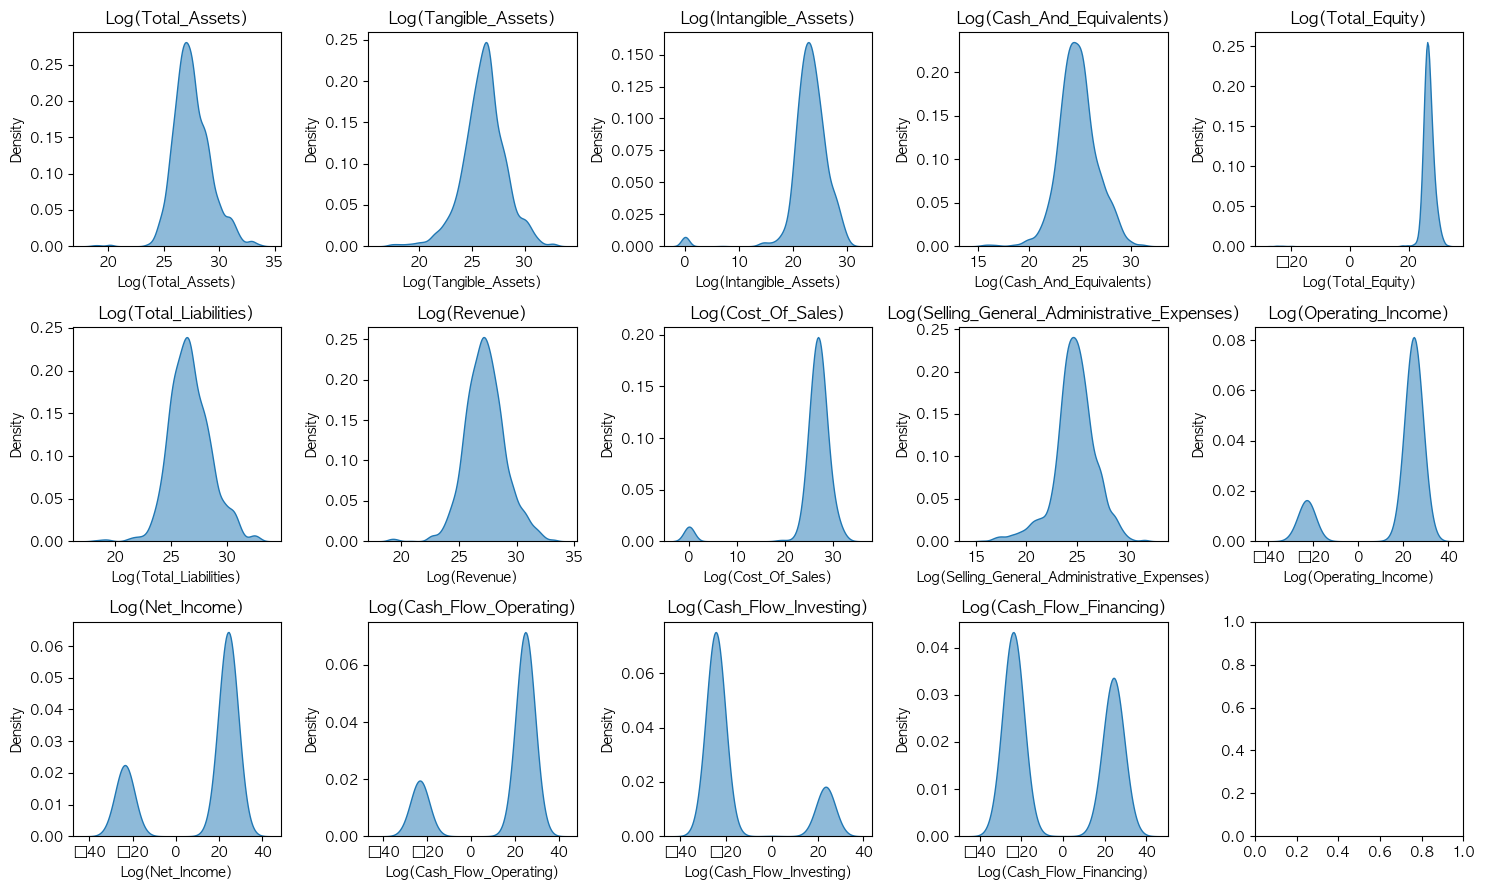

In [100]:
metrics = main_fs['label_en'].unique() 

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for metric, ax in zip(metrics, axes.flatten()):
    plot_metric_distribution(main_fs, metric, ax)

plt.tight_layout()
plt.show()

In [84]:
main_fs['label_en'].unique()

array(['total_assets', 'tangible_assets', 'intangible_assets',
       'cash_and_equivalents', 'total_equity', 'total_liabilities',
       'revenue', 'cost_of_sales',
       'selling_general_administrative_expenses', 'operating_income',
       'net_income', 'cash_flow_operating', 'cash_flow_investing',
       'cash_flow_financing'], dtype=object)

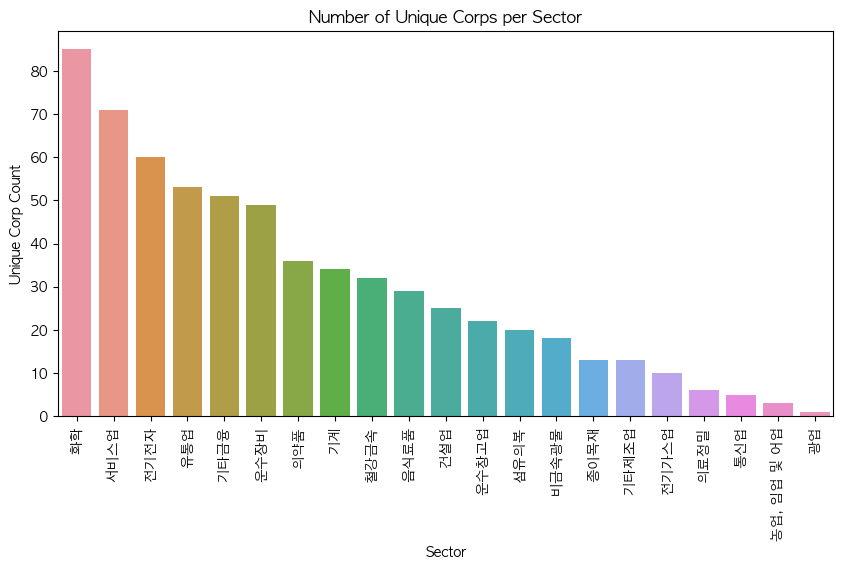

In [75]:
unique_corp_counts = data.groupby('sector')['corp'].nunique()
sorted_unique_corp_counts = unique_corp_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_unique_corp_counts.index, y=sorted_unique_corp_counts.values)
plt.xlabel('Sector')
plt.ylabel('Unique Corp Count')
plt.title('Number of Unique Corps per Sector')
plt.xticks(rotation=90)
plt.show()

In [80]:
data

,id,fs_type,corp,stock_code,sector,label_en,label_ko,2018,2019,2020,2021,2022,YoY
0,1,bs,AJ네트웍스,095570,서비스업,total_assets,자산총계,2.575139e+12,1.803255e+12,1.588170e+12,1.355044e+12,1.481445e+12,9.3
1,2,bs,AK홀딩스,006840,기타금융,total_assets,자산총계,3.397931e+12,4.327965e+12,4.152092e+12,4.548737e+12,5.004335e+12,10.0
2,3,bs,BGF,027410,기타금융,total_assets,자산총계,1.624875e+12,1.657381e+12,1.658204e+12,1.981622e+12,1.938014e+12,-2.2
3,4,bs,BGF리테일,282330,유통업,total_assets,자산총계,1.482569e+12,2.172411e+12,2.371170e+12,2.596379e+12,2.946235e+12,13.5
4,5,bs,BYC,001460,섬유의복,total_assets,자산총계,7.384313e+11,6.938829e+11,6.791349e+11,6.844345e+11,6.688720e+11,-2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,8900,cf,후성,093370,화학,cash_flow_financing,재무활동현금흐름,8.504737e+10,8.553574e+10,6.653992e+09,-2.652142e+10,5.621326e+10,-312.0
8900,8901,cf,휠라홀딩스,081660,유통업,cash_flow_financing,재무활동현금흐름,-2.144485e+11,-1.901877e+11,-1.345094e+11,-2.971712e+11,2.935838e+10,-109.9
8901,8902,cf,휴비스,079980,화학,cash_flow_financing,재무활동현금흐름,-6.260516e+09,6.205889e+10,-8.662798e+10,-5.254632e+10,7.188145e+10,-236.8
8902,8903,cf,휴스틸,005010,철강금속,cash_flow_financing,재무활동현금흐름,-9.087606e+10,-1.002629e+10,1.570881e+08,6.847690e+09,4.064248e+10,493.5


/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_76951/1068699720.py:36: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/sjparky/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


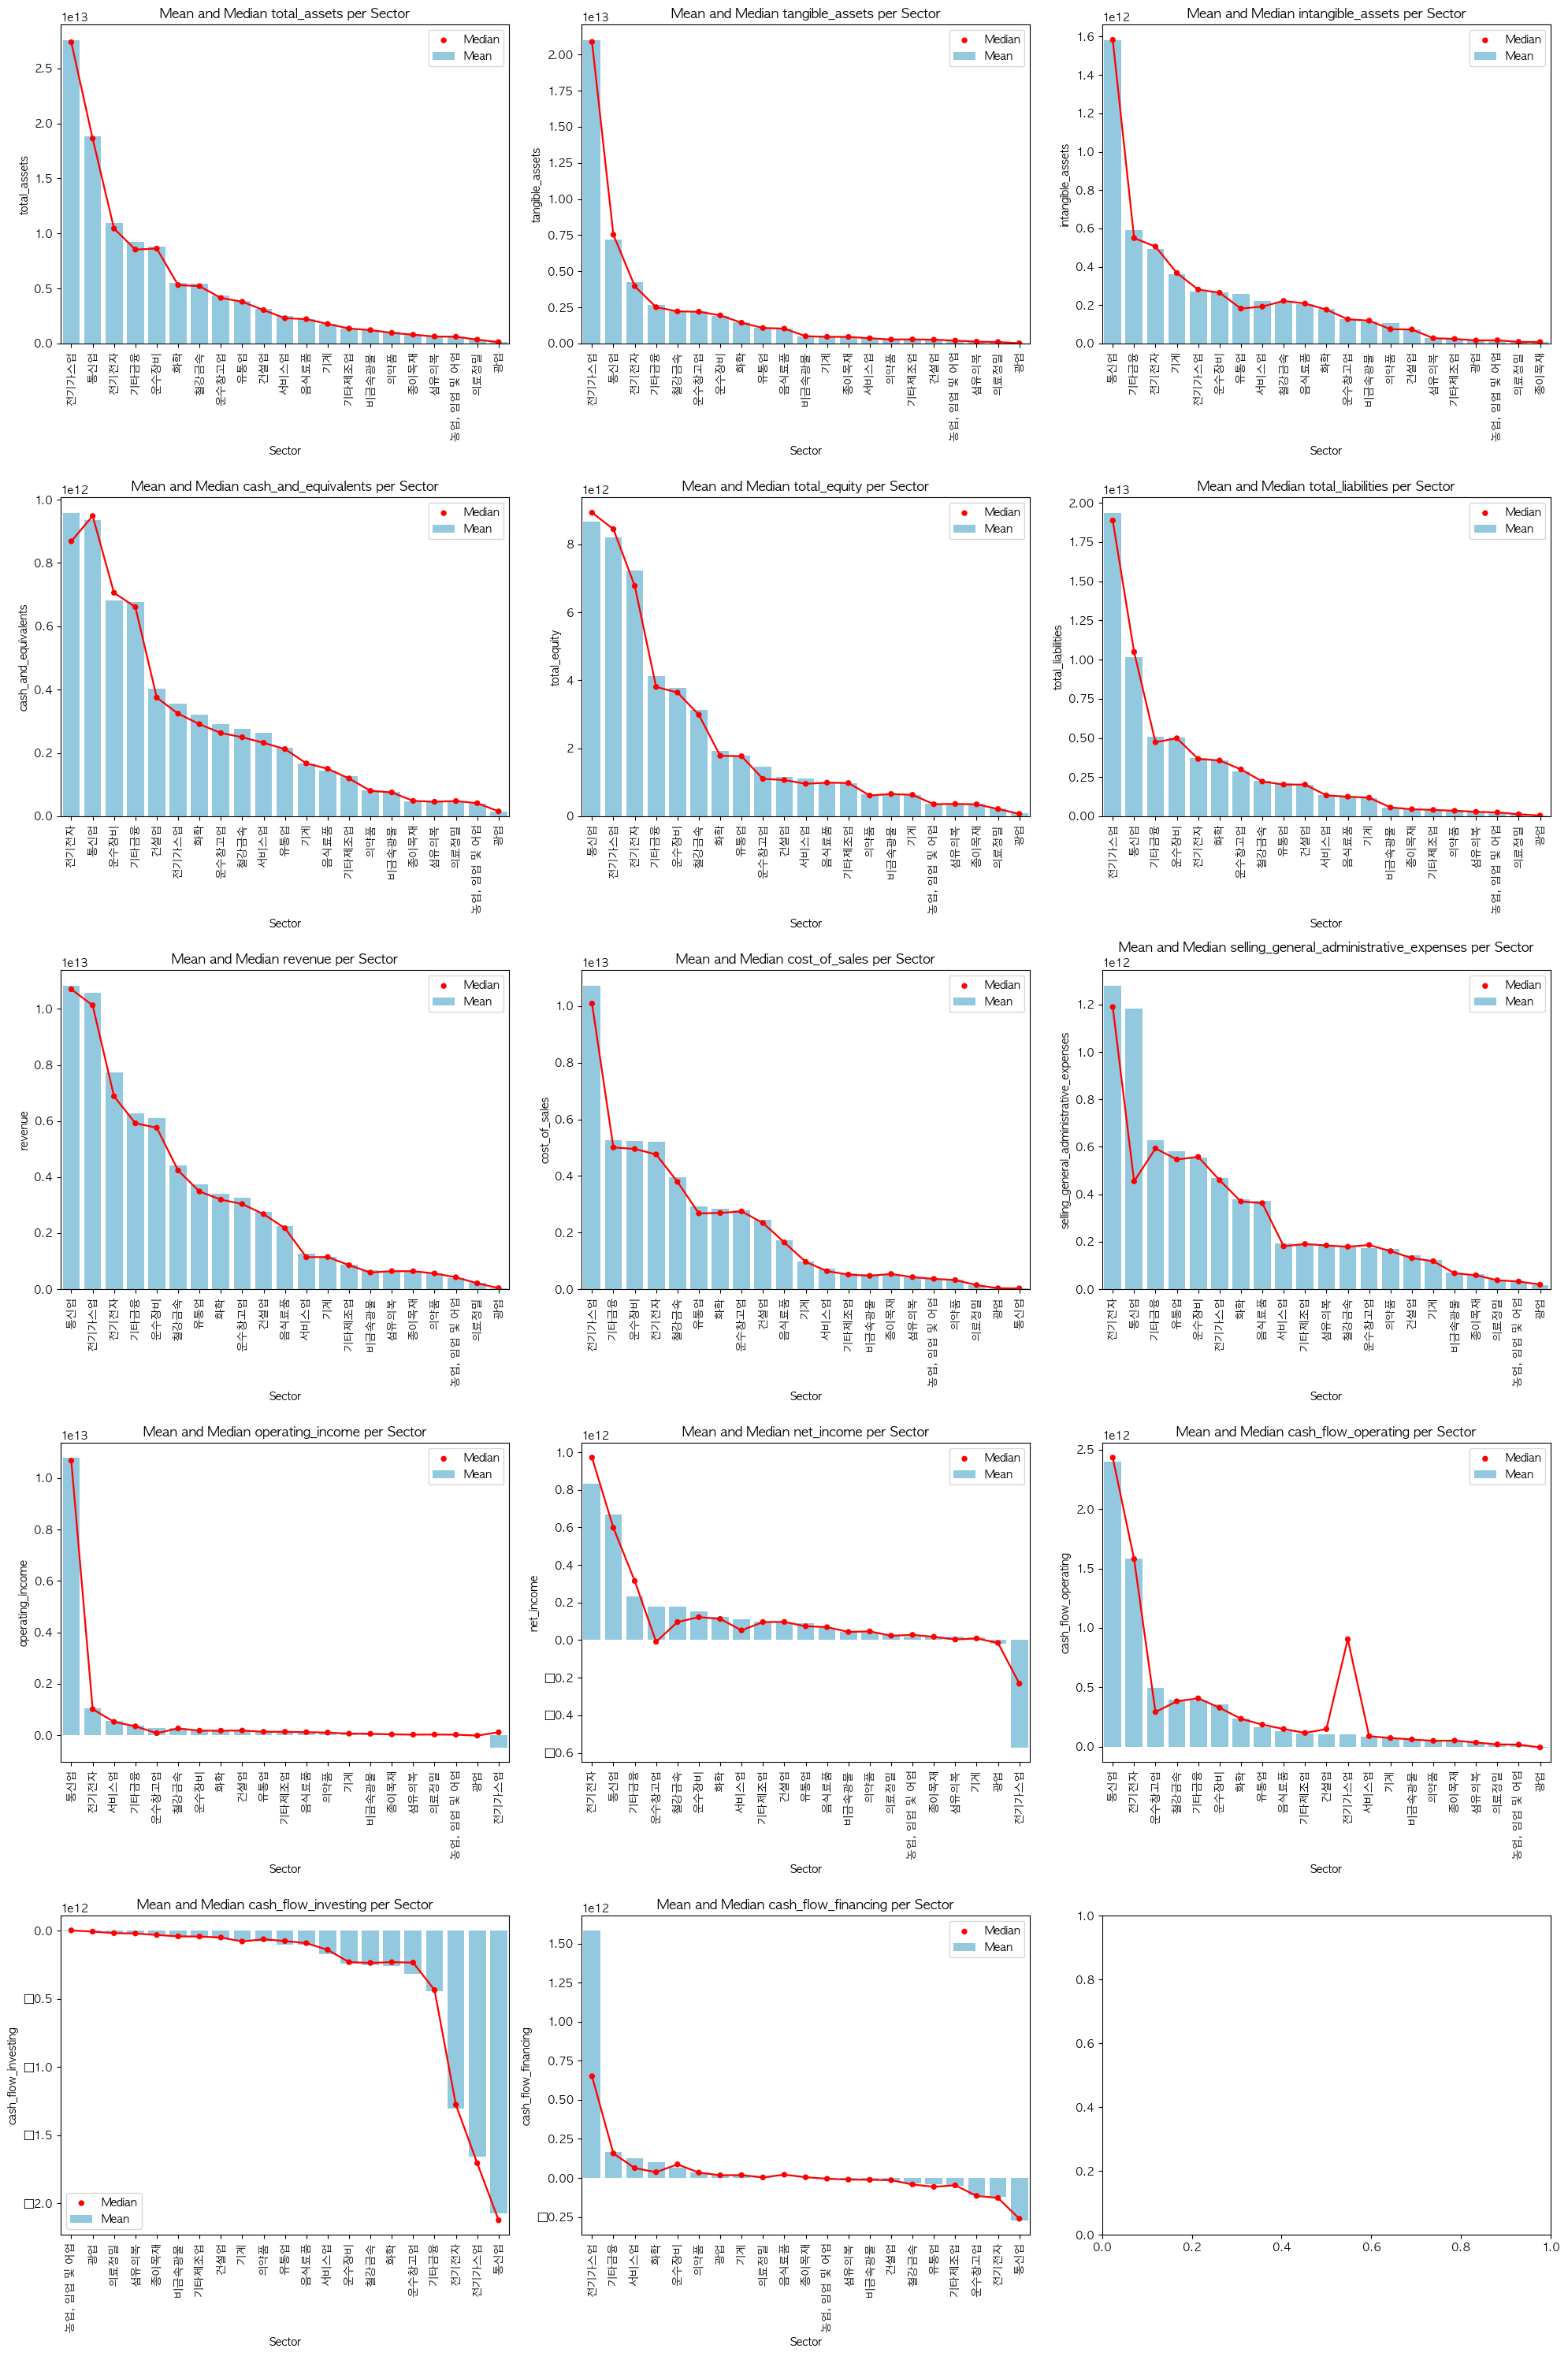

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['font.family'] = 'AppleGothic'


financial_metrics = ['total_assets', 'tangible_assets', 'intangible_assets',
                     'cash_and_equivalents', 'total_equity', 'total_liabilities',
                     'revenue', 'cost_of_sales', 'selling_general_administrative_expenses',
                     'operating_income', 'net_income', 'cash_flow_operating',
                     'cash_flow_investing', 'cash_flow_financing']

try:
    fig, axes = plt.subplots(5, 3, figsize=(20, 30))
    axes = axes.flatten()
    for i, metric in enumerate(financial_metrics):
        
        metric_data = data[data['label_en'] == metric]
        
        summary_stats = metric_data.groupby('sector')[['2018', '2019', '2020', '2021', '2022']].mean().agg(['mean', 'median'], axis=1).sort_values(by='mean', ascending=False)


        sorted_sectors = summary_stats.index

        sns.barplot(x=sorted_sectors, y=summary_stats['mean'], color='skyblue', label='Mean', ax=axes[i])

        sns.pointplot(x=sorted_sectors, y=summary_stats['median'], color='red', label='Median', scale=0.6, ax=axes[i])

        axes[i].set_xlabel('Sector')
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'Mean and Median {metric} per Sector')
        axes[i].tick_params(axis='x', rotation=90)
        axes[i].legend()

    plt.tight_layout()

    plt.show()

except KeyError as e:
    print(f"Error: Missing required column {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


In [99]:
main_fs[main_fs['sector']=='전기가스업']

,id,fs_type,corp,stock_code,sector,label_en,label_ko,2018,2019,2020,2021,2022,YoY
84,85,bs,SGC에너지,005090,전기가스업,total_assets,자산총계,NaN,NaN,2.675393e+12,2.591550e+12,3.054362e+12,17.9
121,122,bs,경동도시가스,267290,전기가스업,total_assets,자산총계,7.782696e+11,7.499995e+11,6.996582e+11,9.044918e+11,1.067615e+12,18.0
174,175,bs,대성에너지,117580,전기가스업,total_assets,자산총계,6.538506e+11,6.971933e+11,7.021170e+11,7.424795e+11,8.344900e+11,12.4
300,301,bs,삼천리,004690,전기가스업,total_assets,자산총계,3.699411e+12,3.912362e+12,3.859948e+12,4.245309e+12,5.021952e+12,18.3
313,314,bs,서울도시가스,017390,전기가스업,total_assets,자산총계,1.368621e+12,1.583402e+12,1.689713e+12,1.662602e+12,1.871342e+12,12.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8706,8707,cf,인천도시가스,034590,전기가스업,cash_flow_financing,재무활동현금흐름,-6.176303e+09,-6.291531e+09,-7.812460e+09,-1.723096e+10,-7.119849e+09,-58.7
8738,8739,cf,지역난방공사,071320,전기가스업,cash_flow_financing,재무활동현금흐름,2.646034e+10,1.813769e+11,5.751310e+10,1.108777e+11,5.488086e+11,395.0
8809,8810,cf,한국가스공사,036460,전기가스업,cash_flow_financing,재무활동현금흐름,NaN,-5.819117e+11,-2.189951e+12,3.475631e+12,1.580211e+13,354.7
8817,8818,cf,한국전력공사,015760,전기가스업,cash_flow_financing,재무활동현금흐름,5.301678e+12,5.775407e+12,1.880824e+12,8.435077e+12,3.899790e+13,362.3


In [95]:
main_fs[main_fs['label_en']=='cash_flow_investing']

,id,fs_type,corp,stock_code,sector,label_en,label_ko,2018,2019,2020,2021,2022,YoY
7632,7633,cf,AJ네트웍스,095570,서비스업,cash_flow_investing,투자활동현금흐름,-4.456029e+10,4.441319e+10,9.685069e+10,1.550796e+11,-2.370629e+10,-115.3
7633,7634,cf,AK홀딩스,006840,기타금융,cash_flow_investing,투자활동현금흐름,-2.246018e+11,-2.193243e+11,-1.856725e+10,-3.824393e+10,-4.637792e+11,1112.7
7634,7635,cf,BGF,027410,기타금융,cash_flow_investing,투자활동현금흐름,2.942273e+10,-4.021998e+08,-2.923150e+10,1.668021e+11,5.798605e+09,-96.5
7635,7636,cf,BGF리테일,282330,유통업,cash_flow_investing,투자활동현금흐름,-3.242159e+11,-2.939092e+11,-2.663609e+11,-2.390892e+11,-9.847990e+10,-58.8
7636,7637,cf,BYC,001460,섬유의복,cash_flow_investing,투자활동현금흐름,-2.146328e+10,4.194407e+10,2.618831e+10,3.766575e+09,4.332194e+10,1050.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8263,8264,cf,후성,093370,화학,cash_flow_investing,투자활동현금흐름,-1.181589e+11,-1.101978e+11,-3.738557e+10,-6.610650e+10,-1.099349e+11,66.3
8264,8265,cf,휠라홀딩스,081660,유통업,cash_flow_investing,투자활동현금흐름,-2.457952e+10,-3.586805e+10,-5.517120e+10,-3.959077e+10,-2.027917e+11,412.2
8265,8266,cf,휴비스,079980,화학,cash_flow_investing,투자활동현금흐름,-5.878647e+10,-5.973663e+10,1.420852e+11,-6.116685e+10,-4.869794e+10,-20.4
8266,8267,cf,휴스틸,005010,철강금속,cash_flow_investing,투자활동현금흐름,7.072134e+09,-1.768658e+10,-2.808339e+10,9.007941e+08,-3.663236e+10,-4166.7


In [ ]:
pd.set_option('display.max_rows', None)  
pd.reset_option('display.max_rows') # Comment this out if want to see the whole dataframe 

features = main_fs['label_en'].unique()
years = ['2018', '2019', '2020', '2021', '2022']

summary_stats = pd.DataFrame()

for feature in features:
    for year in years:
        desc = main_fs[main_fs['label_en'] == feature][year].describe()
        
        desc_df = pd.DataFrame(desc).T
        
        desc_df['feature_year'] = f"{feature}_{year}"
        
        summary_stats = pd.concat([summary_stats, desc_df])

summary_stats.reset_index(drop=True, inplace=True)

summary_stats = summary_stats[['feature_year', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

summary_stats